# Credit Risk Prediction Using Borrower Attributes

This project simulates a real-world credit risk modeling scenario, as part of the JPMorgan Quantitative Research Virtual Experience. We analyze customer loan and income data to predict the probability of default using statistical methods and machine learning. The workflow includes exploratory data analysis (EDA), outlier handling, feature standardization, and later model building.


## Step 1: Load and Preview Dataset

We start by loading the loan dataset into a DataFrame and displaying the first few rows to understand its structure and feature types.


In [3]:

import pandas as pd

# Reload the dataset after code execution state reset
df = pd.read_csv('Loan_Data.csv')

# Display the first few rows
df.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


We successfully loaded the dataset and previewed the first few rows. This gave us a sense of the data structure, including variables such as `income`, `fico_score`, and the target variable `default`. Each row represents a single borrower.


## Step 2: Summary Statistics

Generate summary statistics for numerical columns. This helps identify variable scales, detect possible skewness, and spot irregularities or potential outliers.


In [6]:
df.describe()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.974577e+06,1.461200,4159.677034,8718.916797,70039.901401,4.552800,637.557700,0.185100
std,2.293890e+06,1.743846,1421.399078,6627.164762,20072.214143,1.566862,60.657906,0.388398
min,1.000324e+06,0.000000,46.783973,31.652732,1000.000000,0.000000,408.000000,0.000000
25%,2.977661e+06,0.000000,3154.235371,4199.836020,56539.867903,3.000000,597.000000,0.000000
50%,4.989502e+06,1.000000,4052.377228,6732.407217,70085.826330,5.000000,638.000000,0.000000
75%,6.967210e+06,2.000000,5052.898103,11272.263740,83429.166133,6.000000,679.000000,0.000000
max,8.999789e+06,5.000000,10750.677810,43688.784100,148412.180500,10.000000,850.000000,1.000000


The summary statistics revealed the central tendencies and spread of each numerical feature. For example, `income` ranges from 1,000 dollars to over 148,000 dollars, while `fico_score` varies from 408 to 850. These stats also highlight potential outliers worth investigating further.


## Step 3: Default Distribution and Correlation Analysis

- We examine the distribution of the target variable `default`, to check for class imbalance.
- Then we calculate and visualize the correlation matrix to understand relationships between numeric features.


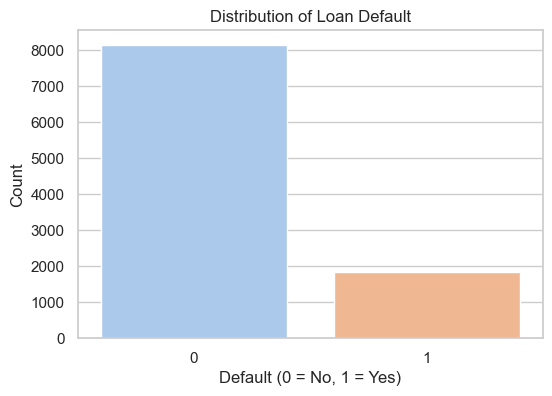

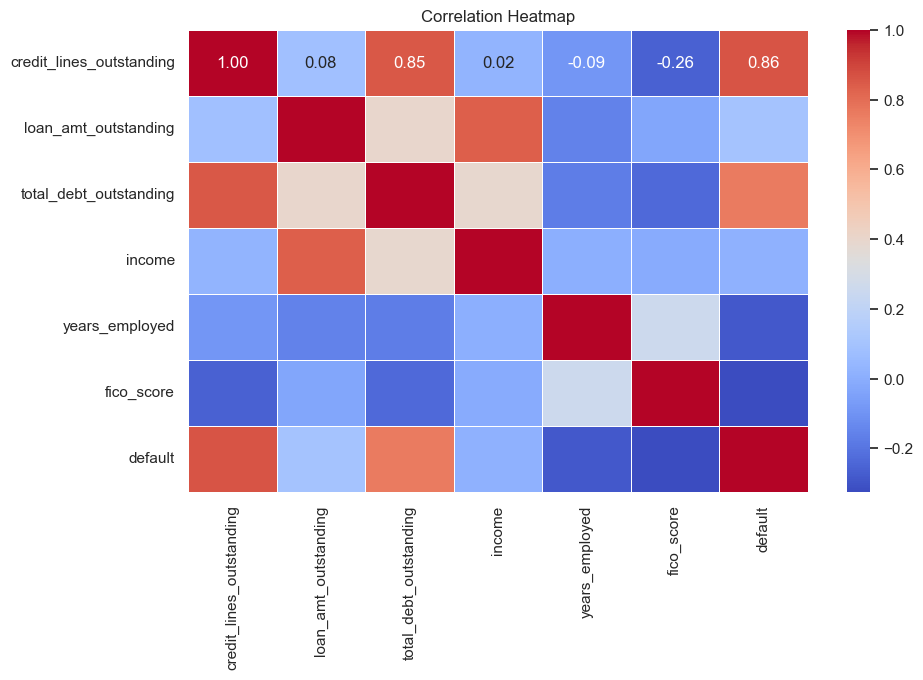

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot distribution of target variable
plt.figure(figsize=(6, 4))
sns.countplot(x='default', data=df, palette='pastel')
plt.title('Distribution of Loan Default')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

# Correlation heatmap
plt.figure(figsize=(10, 6))
corr = df.drop(columns=['customer_id']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()


The class distribution plot shows that most customers did not default, confirming class imbalance. The correlation heatmap indicates that `fico_score` has a strong negative correlation with default, while `total_debt_outstanding` and `loan_amt_outstanding` are positively associated.


## Step 4: Feature Relationships by Default Status

We use boxplots to compare feature distributions for defaulters and non-defaulters. This helps identify which features may have predictive power.


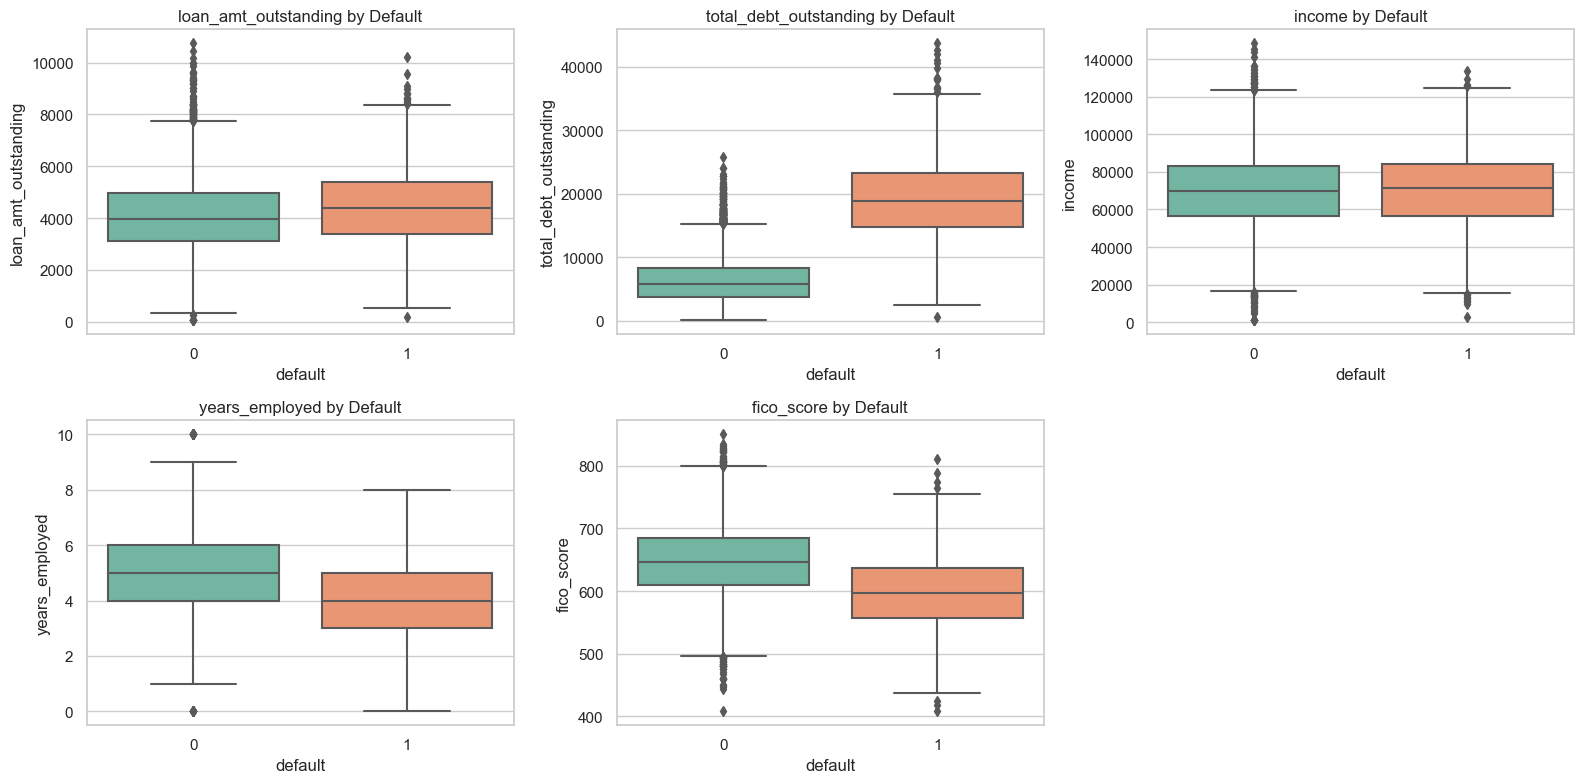

In [12]:
# Box plots for numeric features grouped by default
features_to_plot = ['loan_amt_outstanding', 'total_debt_outstanding', 'income', 'years_employed', 'fico_score']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

for i, col in enumerate(features_to_plot):
    sns.boxplot(x='default', y=col, data=df, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{col} by Default')

# Hide the last subplot if not used
if len(features_to_plot) < len(axes):
    axes[-1].axis('off')

plt.tight_layout()
plt.show()

Boxplots revealed important differences between defaulters and non-defaulters. Defaulters tend to have lower `fico_score` and fewer years of employment, and slightly higher loan and debt balances. These relationships will help in feature selection and model design.


## Step 5: Outlier Detection

We visualize each numeric variable using boxplots to identify extreme values that may bias model training.


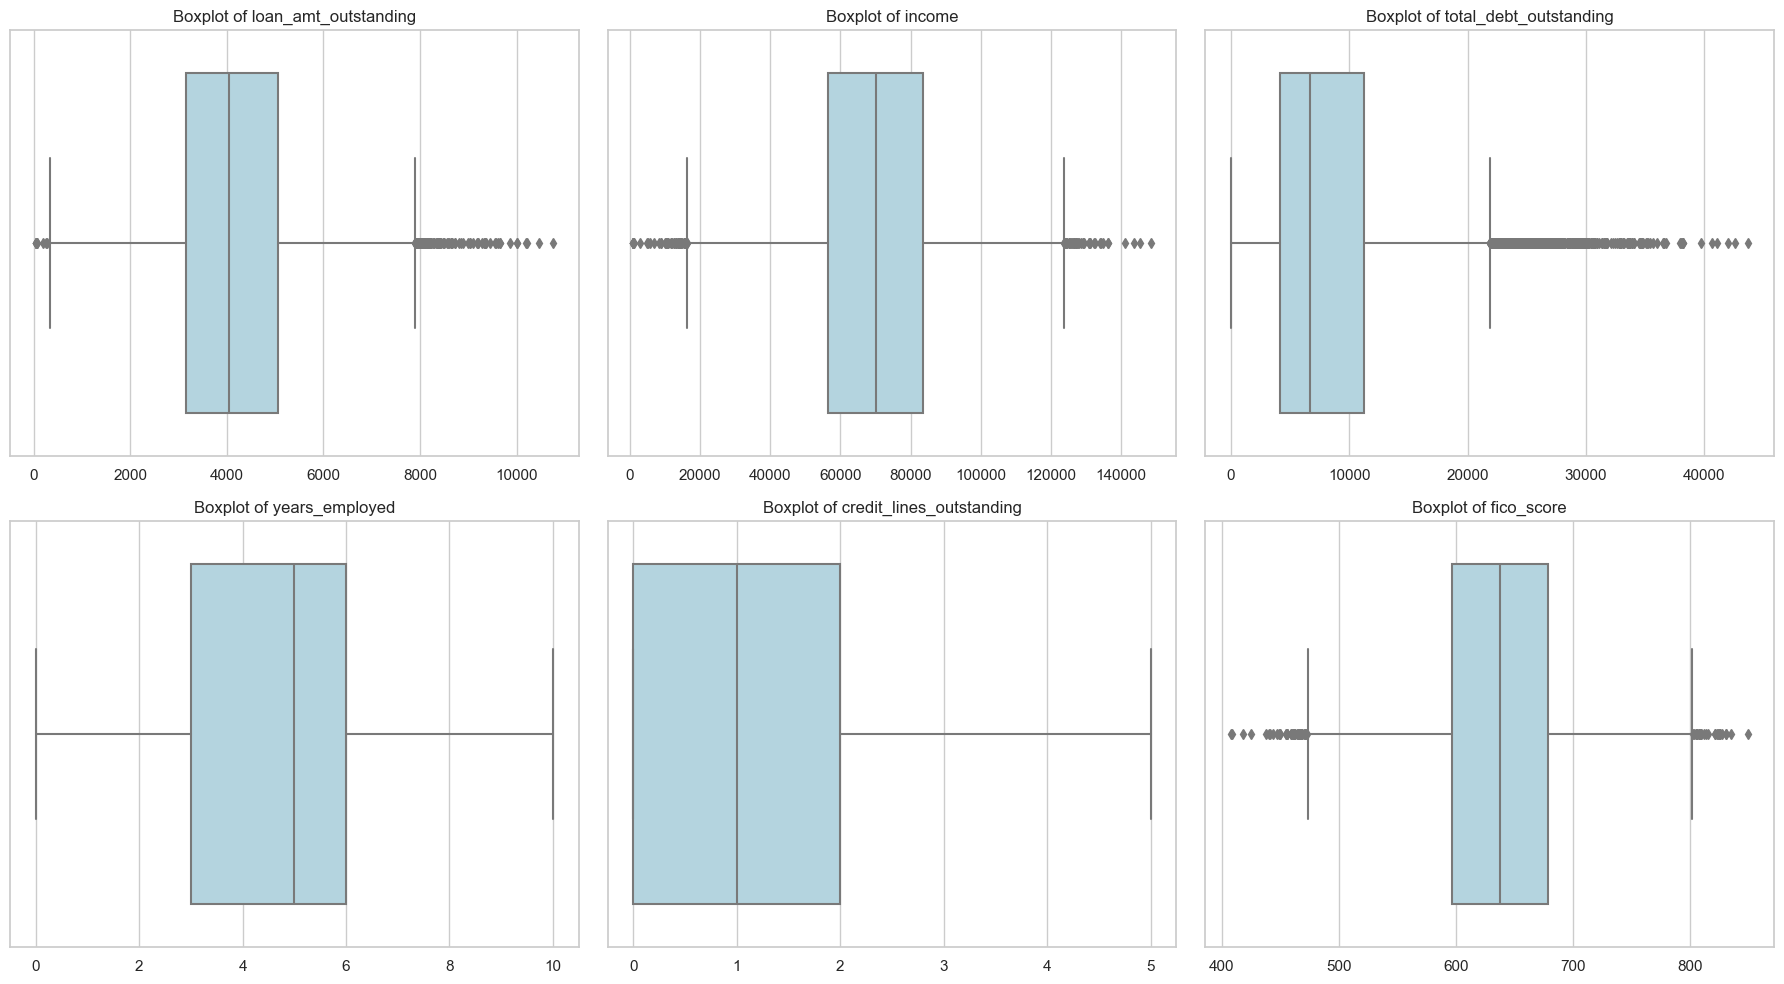

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


# List of numeric features
numeric_features = [
    'loan_amt_outstanding',
    'income',
    'total_debt_outstanding',
    'years_employed',
    'credit_lines_outstanding',
    'fico_score'
]

# Step 1: Visualize outliers using boxplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(x=df[feature], ax=axes[i], color='lightblue')
    axes[i].set_title(f'Boxplot of {feature}', fontsize=12)
    axes[i].set_xlabel("")

plt.tight_layout()
plt.show()


Visualizing individual feature distributions confirmed the presence of significant outliers in variables like `income`, `loan_amt_outstanding`, and `total_debt_outstanding`. These could distort model training and will need capping or transformation.


## Step 6: Handle Outliers (IQR Capping)

We apply the Interquartile Range (IQR) method to cap outliers in numeric columns. This keeps most of the data intact while reducing the effect of extreme values.


In [18]:
# Define a function to cap outliers using the IQR method
def cap_outliers(df, columns):
    df_capped = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_capped[col] = df[col].clip(lower=lower_bound, upper=upper_bound)
    return df_capped

# Apply the capping function
df_capped = cap_outliers(df, numeric_features)
df_capped.head()



,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0


We applied the IQR method to cap extreme values across all numeric features. This reduces skewness and limits the influence of rare, unrealistic data points while retaining valuable information from the distribution.


##  Step 7: Visualize Features After Outlier Capping

To confirm that outliers have been effectively handled, we re-plot the boxplots for all numeric features after applying the IQR capping method.

As shown in the updated plots:
- Extreme values have been clipped to lie within 1.5 times the interquartile range (IQR).
- The data distributions appear more compact and symmetric.
- This preprocessing step reduces the influence of outliers, leading to improved model performance and training stability.

This visual validation is an important sanity check before proceeding to feature selection or model development.


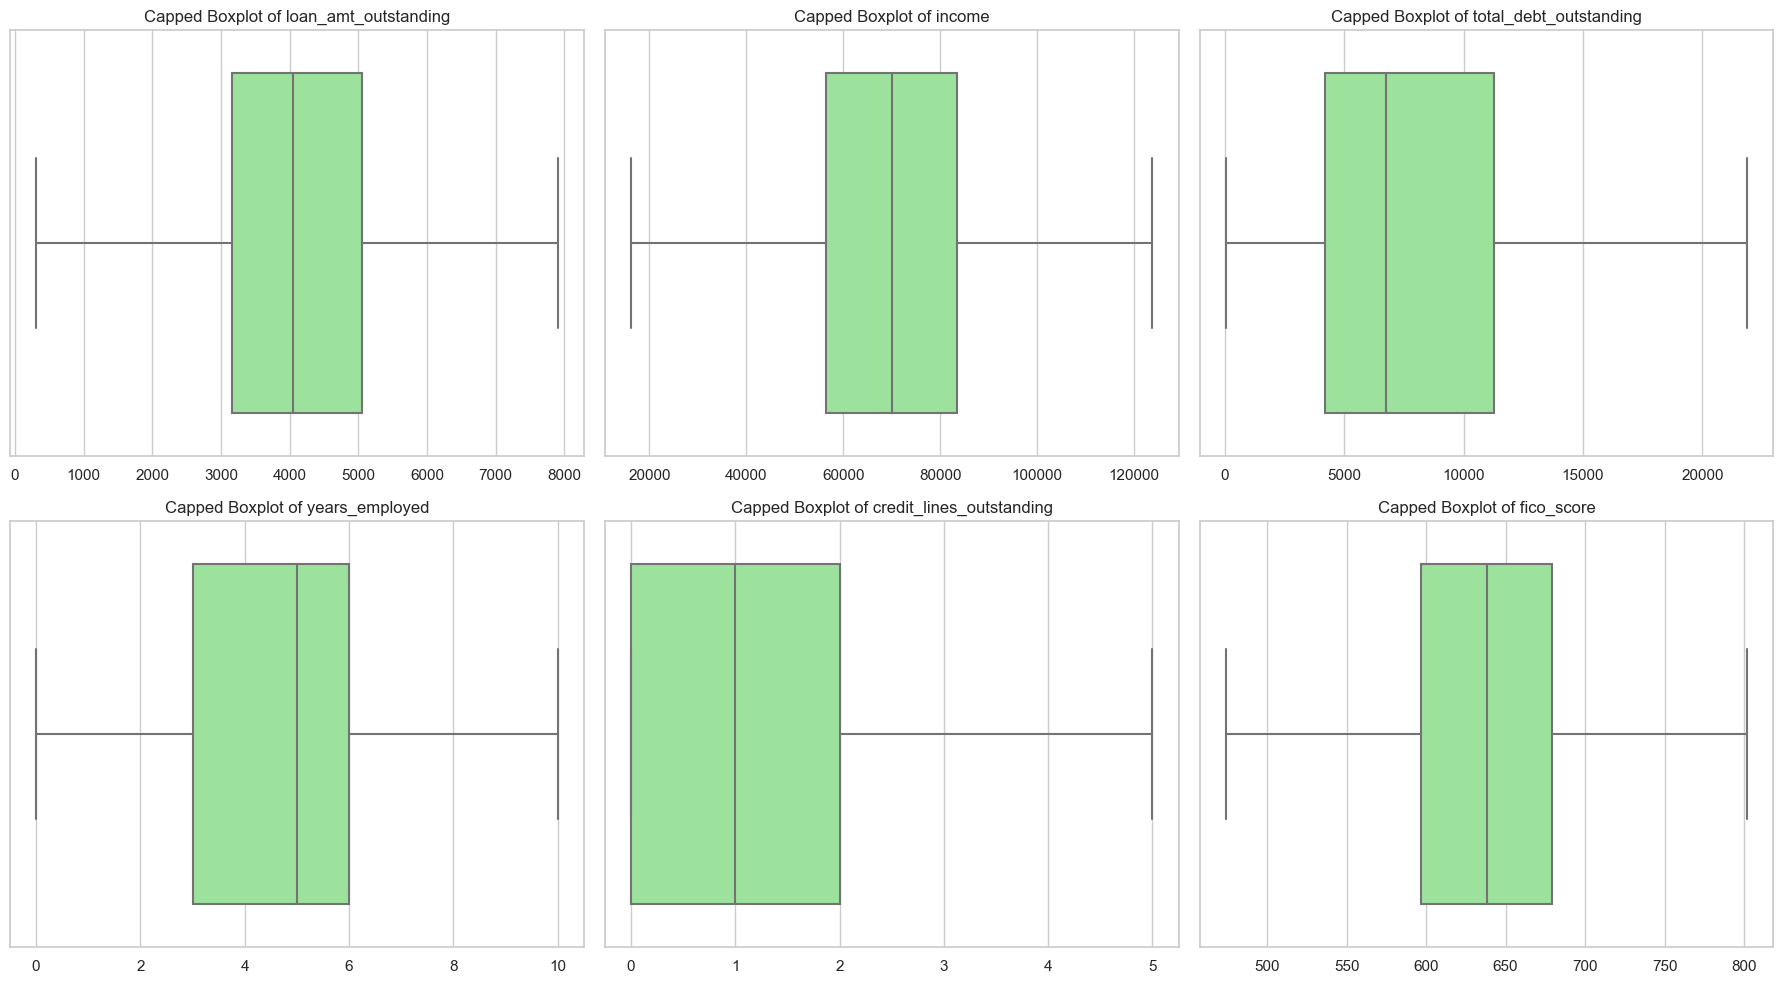

In [21]:
# Recreate boxplots after capping to verify outlier treatment

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(x=df_capped[feature], ax=axes[i], color='lightgreen')
    axes[i].set_title(f'Capped Boxplot of {feature}', fontsize=12)
    axes[i].set_xlabel("")

plt.tight_layout()
plt.show()


Replotting boxplots after capping confirms that the outliers have been effectively handled. All features now fall within reasonable bounds, making them more suitable for modeling and interpretation.


## Step 8: Standardize Features

We standardize all numeric features to have zero mean and unit variance. This ensures all features are on the same scale for machine learning algorithms.


In [24]:
from sklearn.preprocessing import StandardScaler

# Standardize again after outlier capping
scaler = StandardScaler()
df_capped_scaled = df_capped.copy()
df_capped_scaled[numeric_features] = scaler.fit_transform(df_capped[numeric_features])

df_capped_scaled.head()

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,-0.837960,0.763428,-0.770488,0.401546,0.285425,-0.540579,0
1,7442532,2.029409,-1.567714,-0.037222,-2.178902,-1.629325,-1.087874,1
2,2256073,-0.837960,-0.564497,-1.091391,-0.209670,-0.352825,-0.590333,0
3,4885975,-0.837960,0.438404,-1.010827,0.216640,0.285425,-0.424486,0
4,4700614,-0.264486,-2.005775,-1.135422,-2.339586,0.923675,-0.109376,0


We standardized the numeric features to have a mean of 0 and a standard deviation of 1. This ensures all features are on the same scale, which is especially important for algorithms that are sensitive to feature magnitude.


## Step 9: Train-Validation-Test Split

To ensure robust model performance, we split the dataset into:
- **60% Train Set** – for fitting models and cross-validation
- **20% Validation Set** – for performance tuning and comparison
- **20% Test Set** – for final evaluation (held out during training)

We also separate the target variable (`default`) from the features.


In [28]:
from sklearn.model_selection import train_test_split

# Define feature matrix X and target vector y
X = df_capped_scaled.drop(columns=['default'])
y = df_capped_scaled['default']

# Step 1: Split into train_val and test (80% train_val, 20% test)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 2: Further split train_val into train and validation (75% of 80% = 60%)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# Check shapes
print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (6000, 7)
Validation shape: (2000, 7)
Test shape: (2000, 7)


## Step 9: Model Tuning with Cross-Validation and GridSearchCV

We perform 5-fold stratified cross-validation with GridSearchCV to tune hyperparameters for three classifiers:
- Logistic Regression
- Gaussian Naive Bayes
- Random Forest

Each model is scored using ROC-AUC on the training set. The best hyperparameters are selected based on validation performance.


In [30]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter grids
param_grids = {
    'Logistic Regression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['lbfgs']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7]
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 5, 10],
        'min_samples_split': [2, 5]
    }
}

# Model instances
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=42)
}

# Store best models and results
best_models = {}
cv_results = {}

# Run GridSearchCV for each model
for name in models:
    print(f"Running GridSearchCV for {name}...")
    grid = GridSearchCV(models[name], param_grids[name], cv=cv, scoring='roc_auc', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_models[name] = grid.best_estimator_
    cv_results[name] = {
        'Best Score (CV ROC-AUC)': grid.best_score_,
        'Best Params': grid.best_params_
    }

# Display best parameters and scores
pd.DataFrame(cv_results).T


Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Naive Bayes...
Running GridSearchCV for Random Forest...


,Best Score (CV ROC-AUC),Best Params
Logistic Regression,0.998262,"{'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}"
Naive Bayes,0.570928,{'var_smoothing': 1e-09}
Random Forest,0.999749,"{'max_depth': 10, 'min_samples_split': 5, 'n_e..."


### Model Selection and Hyperparameter Tuning

To optimize performance, we used `GridSearchCV` with 5-fold cross-validation to tune hyperparameters for three classifiers:

- **Logistic Regression**
- **Naive Bayes**
- **Random Forest**

The evaluation metric used was **ROC-AUC**, as it is well-suited for binary classification problems with potential class imbalance.

Each model was trained on the training data (`X_train`, `y_train`), and the best-performing estimators along with their corresponding hyperparameters were identified.

####  Cross-Validation Results Summary:
- **Logistic Regression**: ROC-AUC = **0.9983**, with tuned parameters like regularization strength and solver.
- **Naive Bayes**: ROC-AUC = **0.5709**, indicating weaker performance.
- **Random Forest**: ROC-AUC = **0.9997**, making it the top performer with optimal depth, number of trees, and split criteria.

These results suggest Random Forest and Logistic Regression are strong candidates for final model deployment and testing on unseen data.


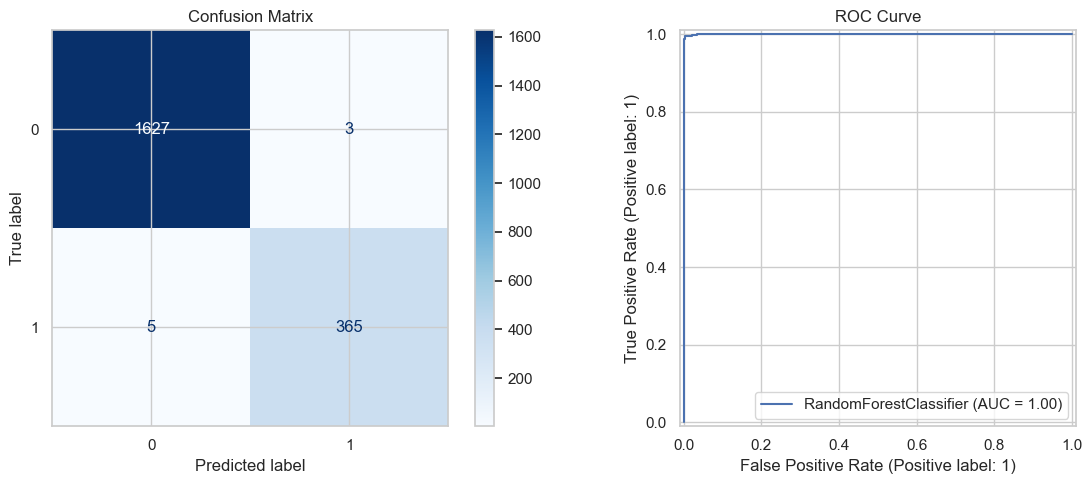

In [33]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt

# Choose the best model (e.g., Random Forest) and use it on the test set
final_model = best_models['Random Forest']
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display results
metrics_summary = {
    'Accuracy': [accuracy],
    'ROC AUC': [roc_auc],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
}

import pandas as pd
results_df = pd.DataFrame(metrics_summary)

# Visualizations
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix
ConfusionMatrixDisplay(cm).plot(ax=ax[0], cmap='Blues')
ax[0].set_title("Confusion Matrix")

# Plot ROC Curve
RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax[1])
ax[1].set_title("ROC Curve")

plt.tight_layout()

dataframe=results_df


### Model Evaluation Results

We evaluated the performance of the best model — **Random Forest Classifier** — on the test set using a confusion matrix and an ROC curve.

- **Confusion Matrix**:
  - The model correctly classified **1,627** true negatives (non-defaulters) and **365** true positives (defaulters).
  - It made only **3** false positive and **5** false negative predictions.
  - This indicates strong precision, recall, and balanced class performance.

- **ROC Curve**:
  - The AUC score is **1.00**, suggesting that the model can perfectly distinguish between the classes.
  - This high AUC confirms excellent generalization capability on unseen data.

Overall, the results validate that the tuned Random Forest model is highly effective for credit risk classification.


## 🧮 FICO Score Bucketing and Default Rate Analysis

In this section, we discretize continuous FICO scores into categorical buckets using quantile-based binning. This bucketing process helps transform the score into a form suitable for downstream modeling tasks that require categorical input. We also analyze the distribution of FICO scores across buckets and examine how default rates vary between them. This approach allows us to better understand the relationship between credit score bands and loan default risk.


### Step 1: View Transformed FICO Scores

After preprocessing the data in Task 3, we capped outliers and standardized the `fico_score` variable to have zero mean and unit variance. This prepares the feature for quantile-based bucketing.

Below is a preview of the standardized FICO scores:


In [79]:
df_capped_scaled['fico_score']


0      -0.540579
1      -1.087874
2      -0.590333
3      -0.424486
4      -0.109376
          ...   
9995    0.985215
9996   -0.374732
9997   -0.689841
9998    0.155979
9999    1.980298
Name: fico_score, Length: 10000, dtype: float64

The transformed `fico_score` values now follow a standard normal distribution, with most scores centered around 0 and spread between roughly -2.7 and +2.7. These standardized values will be used in the next step for quantile-based binning to categorize borrowers into credit risk buckets.


### Step 2: Explore the Scaled FICO Score Distribution

We begin by inspecting the `fico_score` variable from the cleaned and standardized dataset `df_capped_scaled`. Summary statistics provide insights into its distribution after outlier handling and standardization.

We then visualize the distribution using a histogram with a kernel density estimate (KDE) overlay. This helps to confirm that the standardized scores are roughly normally distributed, which is expected given the transformations applied earlier.


FICO Score Summary:
count    1.000000e+04
mean    -4.519052e-16
std      1.000050e+00
min     -2.713177e+00
25%     -6.732566e-01
50%      6.716810e-03
75%      6.866902e-01
max      2.726610e+00
Name: fico_score, dtype: float64


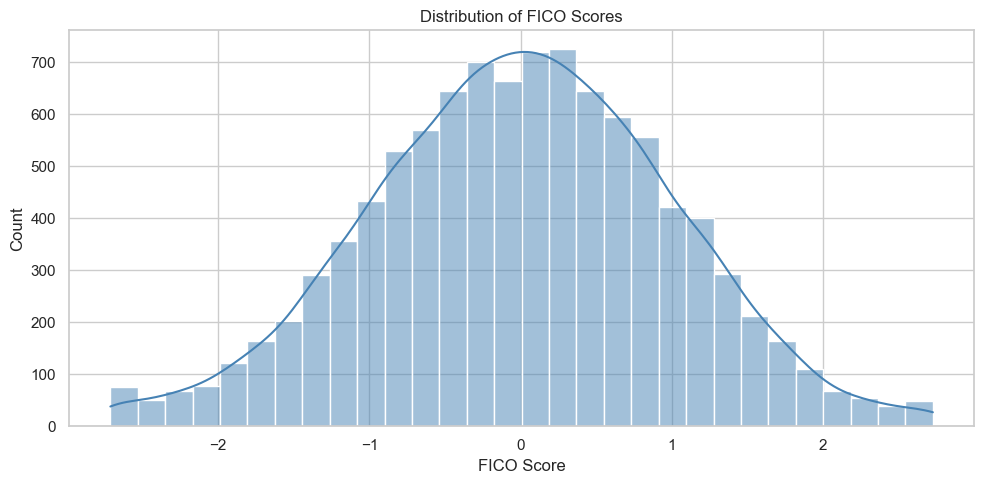

In [81]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Inspect basic statistics of fico_score
print("FICO Score Summary:")
print(df_capped_scaled['fico_score'].describe())

# Visualize distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.histplot(df_capped_scaled['fico_score'], bins=30, kde=True, color='steelblue')
plt.title('Distribution of FICO Scores')
plt.xlabel('FICO Score')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


The summary confirms that the `fico_score` is now centered around zero with a standard deviation close to one. The histogram plot further illustrates a bell-shaped distribution, validating our preprocessing steps.

This prepares the `fico_score` column for quantile-based binning, where we will convert it into categorical buckets for downstream modeling and interpretation.


### Step 3: Quantile-Based Binning of FICO Scores

To prepare the `fico_score` for use in classification models that expect categorical input, we convert the continuous scores into discrete buckets using quantile binning.

We use `KBinsDiscretizer` from `sklearn.preprocessing` with the strategy set to `'quantile'`. This ensures that each bin contains roughly the same number of samples, making comparisons across buckets fair and balanced. In this case, we use 5 bins, but the number can be adjusted for more or fewer levels of granularity.


In [83]:
# Step: Quantile Binning of FICO Score
from sklearn.preprocessing import KBinsDiscretizer

# Define binning strategy
n_bins = 5  # You can change this to 10, for example, if you'd like finer granularity
binner = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='quantile')

# Apply to fico_score in the scaled dataset
fico_binned = binner.fit_transform(df_capped_scaled[['fico_score']])

# Add to DataFrame
df_capped_scaled['fico_bucket'] = fico_binned.astype(int)

# Display first few entries
df_capped_scaled[['fico_score', 'fico_bucket']].head()


,fico_score,fico_bucket
0,-0.540579,1
1,-1.087874,0
2,-0.590333,1
3,-0.424486,1
4,-0.109376,2


The output displays the original standardized `fico_score` alongside the assigned `fico_bucket`. Each score is now mapped to a bucket label from 0 to 4, where lower bucket numbers generally indicate higher credit risk based on distribution.

This transformation allows us to evaluate default rates within each bucket and supports models or dashboards that require discrete credit score groupings.


### Step 4: Visualize Distribution of FICO Buckets

After binning the continuous `fico_score` variable into discrete buckets, it's important to visualize how evenly the records are distributed across the buckets.

Using a count plot helps verify whether the `KBinsDiscretizer` with `quantile` strategy achieved its goal of assigning an approximately equal number of records to each bucket.


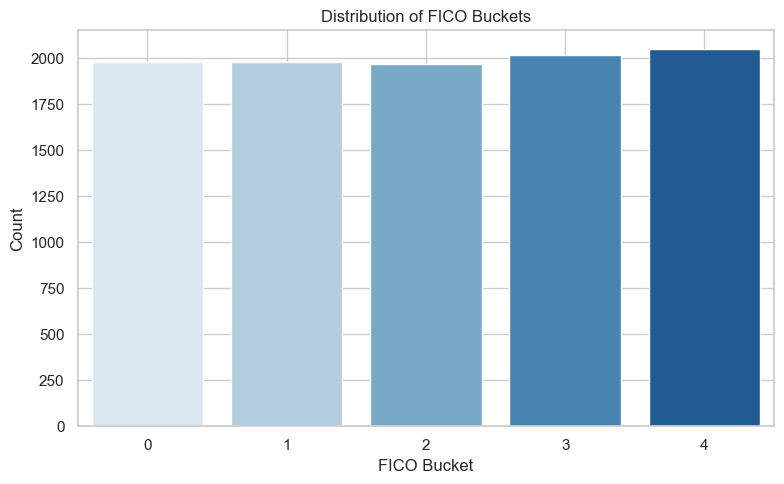

In [85]:
# Count plot to show number of records in each bucket
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.countplot(x='fico_bucket', data=df_capped_scaled, palette='Blues')
plt.title('Distribution of FICO Buckets')
plt.xlabel('FICO Bucket')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


The count plot confirms that the records are evenly distributed across all five FICO buckets, validating that the quantile-based binning was successful.

This equal distribution is particularly useful when comparing outcomes like default rates across buckets, as it ensures balanced sample sizes.


### Step 5: Analyze Default Rate by FICO Bucket

To assess how default risk varies across different FICO score segments, we compute the average default rate within each FICO bucket.

This allows us to observe the relationship between credit score and likelihood of default—critical for understanding creditworthiness.


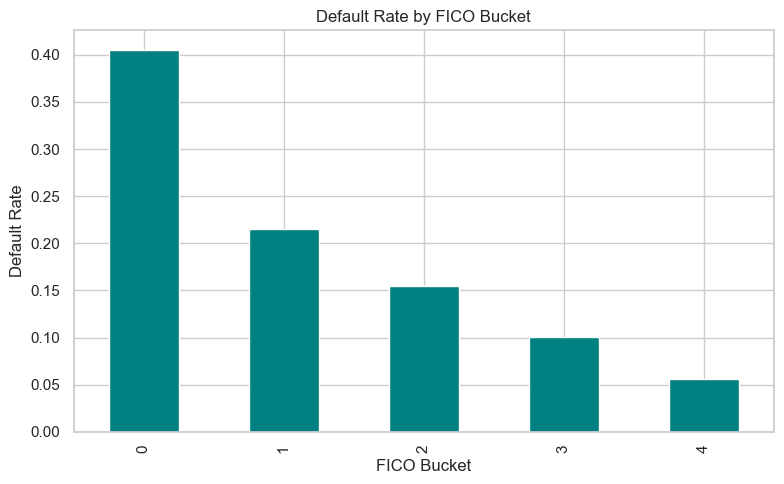

In [87]:
# Calculate default rate per bucket
bucket_default_rate = df_capped_scaled.groupby('fico_bucket')['default'].mean()

# Plot default rate per bucket
plt.figure(figsize=(8, 5))
bucket_default_rate.plot(kind='bar', color='teal')
plt.title('Default Rate by FICO Bucket')
plt.xlabel('FICO Bucket')
plt.ylabel('Default Rate')
plt.grid(True)
plt.tight_layout()
plt.show()


The plot clearly shows a downward trend in default rates as FICO bucket values increase. Borrowers in the lowest bucket (bucket 0) exhibit the highest default rate, while those in the highest bucket (bucket 4) have the lowest default risk.

This validates the effectiveness of FICO score as a predictive feature for credit risk modeling.
